# DenseNet 201 Analysis

## Library Import

In [ ]:
import tensorflow 

import numpy as np
import keras
import math
import seaborn as sns

from matplotlib import pyplot

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization,Activation
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout,UpSampling2D
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

print("Tensorflow-version:", tensorflow.__version__)

Tensorflow-version: 2.3.0


## Load Data from Keras

In [ ]:
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.cifar100.load_data()

num_classes = 100
nb_epochs = 10
batch_size = 64

def preprocess_data(X, Y):
    """
    function that pre-processes the CIFAR10 dataset as per
    densenet model requirements for input images
    labels are one-hot encoded
    """
    X = tensorflow.keras.applications.densenet.preprocess_input(X)
    Y = tensorflow.keras.utils.to_categorical(Y)
    return X, Y

x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

Train: X=(50000, 32, 32, 3), y=(50000, 100)
Test: X=(10000, 32, 32, 3), y=(10000, 100)


## DenseNet 201 Model

We utilize ImageDataGenerator to augment our input data.  This should help us avoid overfitting.

In [ ]:
densenet_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in densenet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

model = Sequential()
model.add(UpSampling2D(size=(7,7)))
model.add(densenet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(.25))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))


#model.summary()
#tf.keras.utils.plot_model( model , show_shapes=True )

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy'])

batch_size = 64
epochs = 10

anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(rotation_range=8,
                             shear_range=0.2, 
                             zoom_range=0.2,
                             channel_shift_range=0.05, 
                             horizontal_flip=True)

datagen.fit(x_train)

# Fits-the-model
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
               steps_per_epoch=x_train.shape[0] // batch_size,
               epochs=epochs,
               verbose=1,
               callbacks=[anne, checkpoint],
               validation_data=(x_test, y_test))

Epoch 1/10
781/781 [==============================] - ETA: 0s - loss: 1.6548 - accuracy: 0.5630 - top_k_categorical_accuracy: 0.8324
Epoch 00001: val_loss improved from inf to 0.98455, saving model to model.h5
781/781 [==============================] - 699s 895ms/step - loss: 1.6548 - accuracy: 0.5630 - top_k_categorical_accuracy: 0.8324 - val_loss: 0.9846 - val_accuracy: 0.7091 - val_top_k_categorical_accuracy: 0.9362
Epoch 2/10
781/781 [==============================] - ETA: 0s - loss: 0.9249 - accuracy: 0.7264 - top_k_categorical_accuracy: 0.9450
Epoch 00002: val_loss improved from 0.98455 to 0.83559, saving model to model.h5
781/781 [==============================] - 692s 886ms/step - loss: 0.9249 - accuracy: 0.7264 - top_k_categorical_accuracy: 0.9450 - val_loss: 0.8356 - val_accuracy: 0.7520 - val_top_k_categorical_accuracy: 0.9535
Epoch 3/10
781/781 [==============================] - ETA: 0s - loss: 0.7990 - accuracy: 0.7604 - top_k_categorical_accuracy: 0.9563
Epoch 00003: val_

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_1 (UpSampling2 (None, 224, 224, 3)       0         
_________________________________________________________________
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               491776    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 100)              

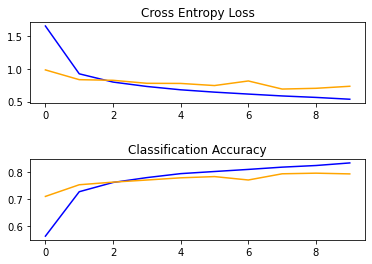

In [ ]:
def summarize_diagnostics(history):
    pyplot.subplots_adjust(hspace=0.7)
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    
    # save plot to file
    filename = "DenseNet201_Pretrained"
    pyplot.savefig(filename + '_plot.png')
    

summarize_diagnostics(history)

## Final Prediciton

In [ ]:
model = keras.models.load_model('/content/model.h5')
ypred = model.predict(x_test)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(y_test[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 10000 	accurately-predicted-data: 7923 	 wrongly-predicted-data:  2077
Accuracy: 79.23 %


### Heat Map

Text(0.5, 283.0137499999999, 'Predicted')

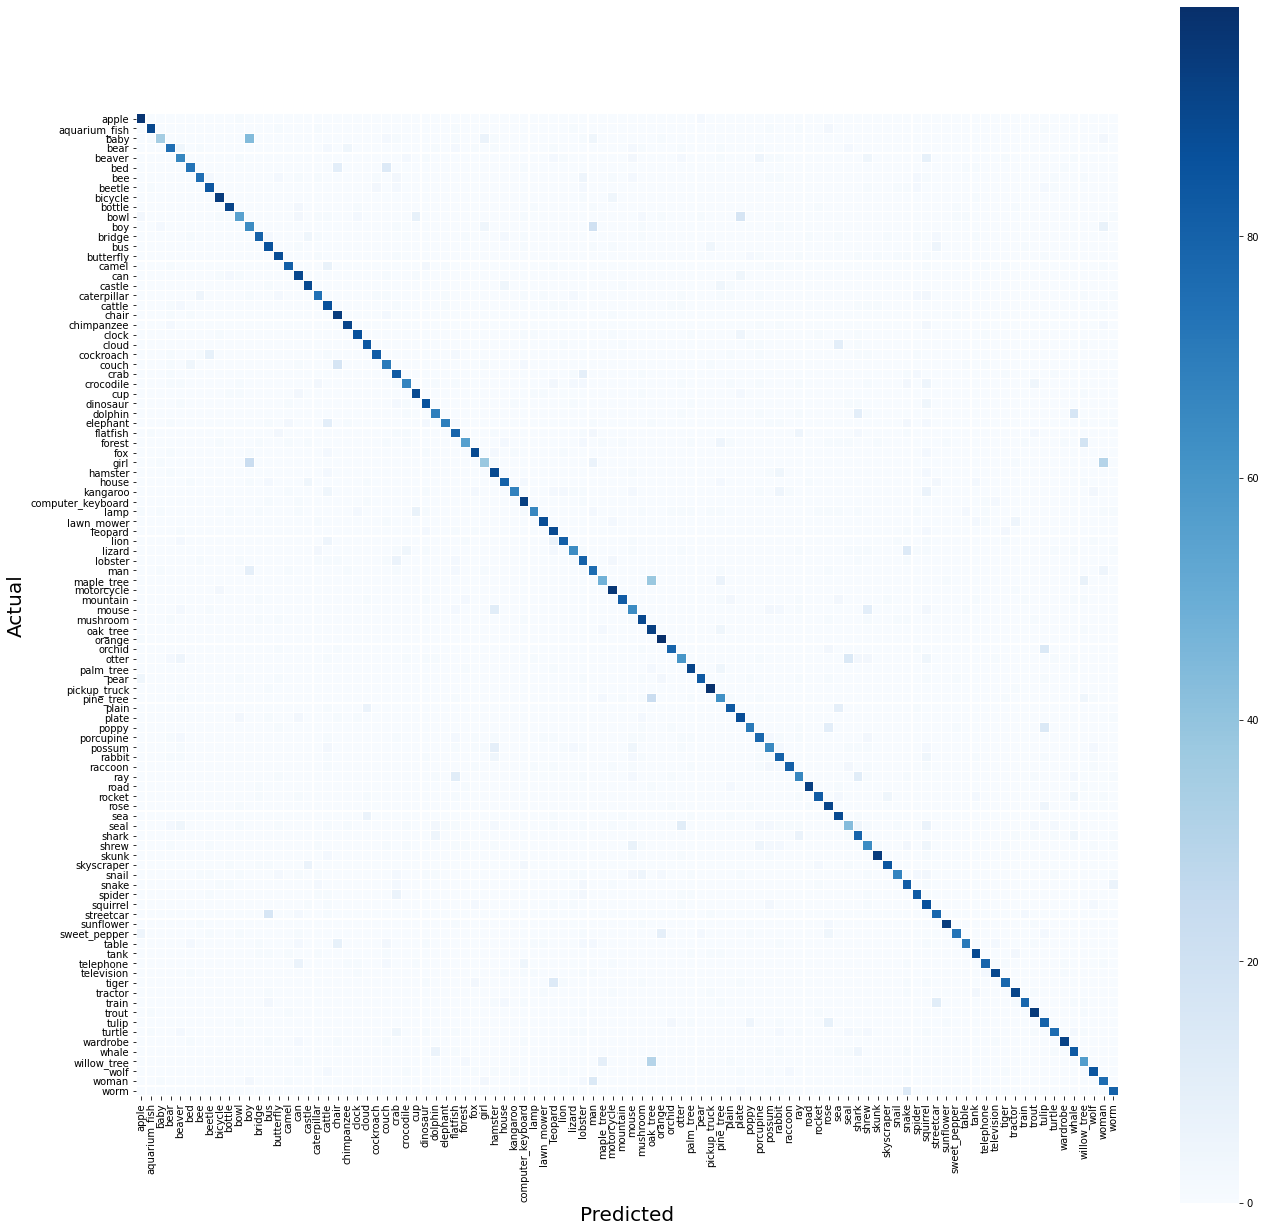

In [ ]:
Ypred = model.predict(x_test)

Ypred = np.argmax(Ypred, axis=1)
Ytrue = np.argmax(y_test, axis=1)

cm = confusion_matrix(Ytrue, Ypred)
plt.figure(figsize=(22, 22))
ax = sns.heatmap(cm, cmap="Blues", 
                 fmt=".01f",
                 annot_kws={'size':16}, 
                 annot=False, 
                 square=True, 
                 linewidths=0.1, 
                 xticklabels=fine_labels, 
                 yticklabels=fine_labels)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

In [ ]:
fine_labels = [
    'apple',  # id 0
    'aquarium_fish',
    'baby',
    'bear',
    'beaver',
    'bed',
    'bee',
    'beetle',
    'bicycle',
    'bottle',
    'bowl',
    'boy',
    'bridge',
    'bus',
    'butterfly',
    'camel',
    'can',
    'castle',
    'caterpillar',
    'cattle',
    'chair',
    'chimpanzee',
    'clock',
    'cloud',
    'cockroach',
    'couch',
    'crab',
    'crocodile',
    'cup',
    'dinosaur',
    'dolphin',
    'elephant',
    'flatfish',
    'forest',
    'fox',
    'girl',
    'hamster',
    'house',
    'kangaroo',
    'computer_keyboard',
    'lamp',
    'lawn_mower',
    'leopard',
    'lion',
    'lizard',
    'lobster',
    'man',
    'maple_tree',
    'motorcycle',
    'mountain',
    'mouse',
    'mushroom',
    'oak_tree',
    'orange',
    'orchid',
    'otter',
    'palm_tree',
    'pear',
    'pickup_truck',
    'pine_tree',
    'plain',
    'plate',
    'poppy',
    'porcupine',
    'possum',
    'rabbit',
    'raccoon',
    'ray',
    'road',
    'rocket',
    'rose',
    'sea',
    'seal',
    'shark',
    'shrew',
    'skunk',
    'skyscraper',
    'snail',
    'snake',
    'spider',
    'squirrel',
    'streetcar',
    'sunflower',
    'sweet_pepper',
    'table',
    'tank',
    'telephone',
    'television',
    'tiger',
    'tractor',
    'train',
    'trout',
    'tulip',
    'turtle',
    'wardrobe',
    'whale',
    'willow_tree',
    'wolf',
    'woman',
    'worm']